# **Capstone 3: Hotel Booking Cancellation Classification**

**By: Muhammad Raihan**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble various
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import VotingRegressor, StackingRegressor

# ensemble similar
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score 

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# **Business Problem Understanding**
**Context:**

In the hospitality industry, managing hotel bookings efficiently is critical for maximizing revenue and providing excellent customer service. Understanding booking patterns and predicting cancellations can help hotels optimize room availability, staffing, and revenue management.

**Problem Statement:**

The hotel industry faces challenges in predicting and managing booking cancellations effectively. Without accurate forecasting, hotels may experience revenue loss due to unutilized rooms and inefficient resource allocation.

**Goals:**

1. Develop a predictive model to forecast hotel booking cancellations accurately.
2. Minimize revenue loss caused by canceled bookings by improving the hotel's ability to respond proactively to potential cancellations.
3. Enhance resource allocation and operational efficiency by optimizing room availability and staffing based on predicted booking cancellations.

**Analytic Approach:**

We will leverage historical booking data to train machine learning models that can predict whether a booking is likely to be canceled. The approach involves preprocessing the data, feature engineering to extract relevant information, model selection and tuning, and evaluating model performance.

**Metric Evaluation:**

We will evaluate the performance of the predictive models using the following metrics:

- Accuracy: To measure the overall correctness of the model's predictions.
- Precision: To assess the proportion of correctly predicted cancellations among all predicted cancellations.
- Recall: To measure the proportion of correctly predicted cancellations among all actual cancellations.
- F1 Score: To balance precision and recall, providing a single metric for model evaluation.
- F2 Score: Similar to the F1 Score but places more emphasis on recall, which is crucial for identifying canceled bookings effectively.


These metrics will help us assess the model's effectiveness in accurately predicting booking cancellations and guide decision-making to optimize hotel operations and revenue management.

## Attribute Information

|Attribute | Data Type, Length | Description
| --- | --- | --- |
|country | Text | Country of origin
|market_segment | Text | Market segment designation
|previous_cancellations | Long | Number of previous bookings that were cancelled by the customer prior to the current booking
|booking_changes | Long | Number of changes/amendments made to the booking from the moment it was entered until check-in or cancellation
|deposit_type | Text | Indication if the customer made a deposit to guarantee the booking
|days_in_waiting_list | Long | Number of days the booking was in the waiting list before it was confirmed to the customer
|customer_type | Text | Type of booking
|reserved_room_type | Text | Code of room type reserved (code presented instead of designation for anonymity reasons)
|required_car_parking_space | Long | Number of car parking spaces required by the customer
|total_of_special_request | Long | Number of special requests made by the customer (e.g. twin bed or high floor)
|is_canceled | Long | Value indicating if the booking was canceled (1) or not (0)

In [2]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


## **Data Cleaning**

In [3]:
pd.DataFrame({
    'Dtype': df.dtypes,
    'Null': df.isna().sum().values,
    'Negative': [len(df[col][df[col] < 0].values) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'Zero(0)': [len(df[col][df[col] == 0].values) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'Duplicate' : df.duplicated().sum(),
    'Nunique': df.nunique(dropna=False).values,
    'Unique': [df[col].unique() for col in df.columns]}
).round(2)

,Dtype,Null,Negative,Zero(0),Duplicate,Nunique,Unique
country,object,351,0,0,73371,163,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, B..."
market_segment,object,0,0,0,73371,8,"[Offline TA/TO, Online TA, Direct, Groups, Cor..."
previous_cancellations,int64,0,0,79060,73371,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19,..."
booking_changes,int64,0,0,70873,73371,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12,..."
deposit_type,object,0,0,0,73371,3,"[No Deposit, Non Refund, Refundable]"
days_in_waiting_list,int64,0,0,80988,73371,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31..."
customer_type,object,0,0,0,73371,4,"[Transient-Party, Transient, Contract, Group]"
reserved_room_type,object,0,0,0,73371,10,"[A, E, D, F, B, G, C, H, L, P]"
required_car_parking_spaces,int64,0,0,78346,73371,5,"[0, 1, 2, 8, 3]"
total_of_special_requests,int64,0,0,49188,73371,6,"[0, 2, 1, 3, 4, 5]"


In order to make the optimal analysis and build a reliable model, it is crucial to ensure the quality and integrity of our data. This involves several preprocessing steps, including the removal of Null values and duplicated data. Null values, or missing data, can lead to biased results and affect the performance of machine learning models. By addressing these gaps—either by imputation, which involves filling in missing values with estimated ones, or by removing the affected rows or columns—we ensure that our dataset is complete and accurate.

Similarly, duplicated data can skew analysis results and introduce redundancy, leading to overfitting in machine learning models. Overfitting occurs when the model learns the noise in the data rather than the underlying pattern, which diminishes its ability to generalize to new, unseen data. By identifying and removing duplicate records, we maintain the dataset’s uniqueness and ensure that each entry contributes equally to the analysis and model training.

Additionally, these preprocessing steps help in maintaining the integrity of statistical assumptions and improve the computational efficiency of our analysis. Clean and well-preprocessed data is foundational to deriving meaningful insights and building robust predictive models that can perform well on real-world data.

In [4]:
df = df.drop_duplicates()
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83515,GBR,Direct,0,2,No Deposit,0,Transient-Party,A,1,1,0
83543,CHN,Online TA,0,0,No Deposit,0,Transient-Party,C,0,2,0
83554,BEL,Groups,0,0,No Deposit,0,Transient-Party,A,0,1,0
83562,NLD,Online TA,0,0,No Deposit,0,Transient,B,0,0,0


In [5]:
df = df.dropna()
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83515,GBR,Direct,0,2,No Deposit,0,Transient-Party,A,1,1,0
83543,CHN,Online TA,0,0,No Deposit,0,Transient-Party,C,0,2,0
83554,BEL,Groups,0,0,No Deposit,0,Transient-Party,A,0,1,0
83562,NLD,Online TA,0,0,No Deposit,0,Transient,B,0,0,0


In [6]:
cleaned_df = df

# Export the cleaned DataFrame to a CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)

# **EDA**

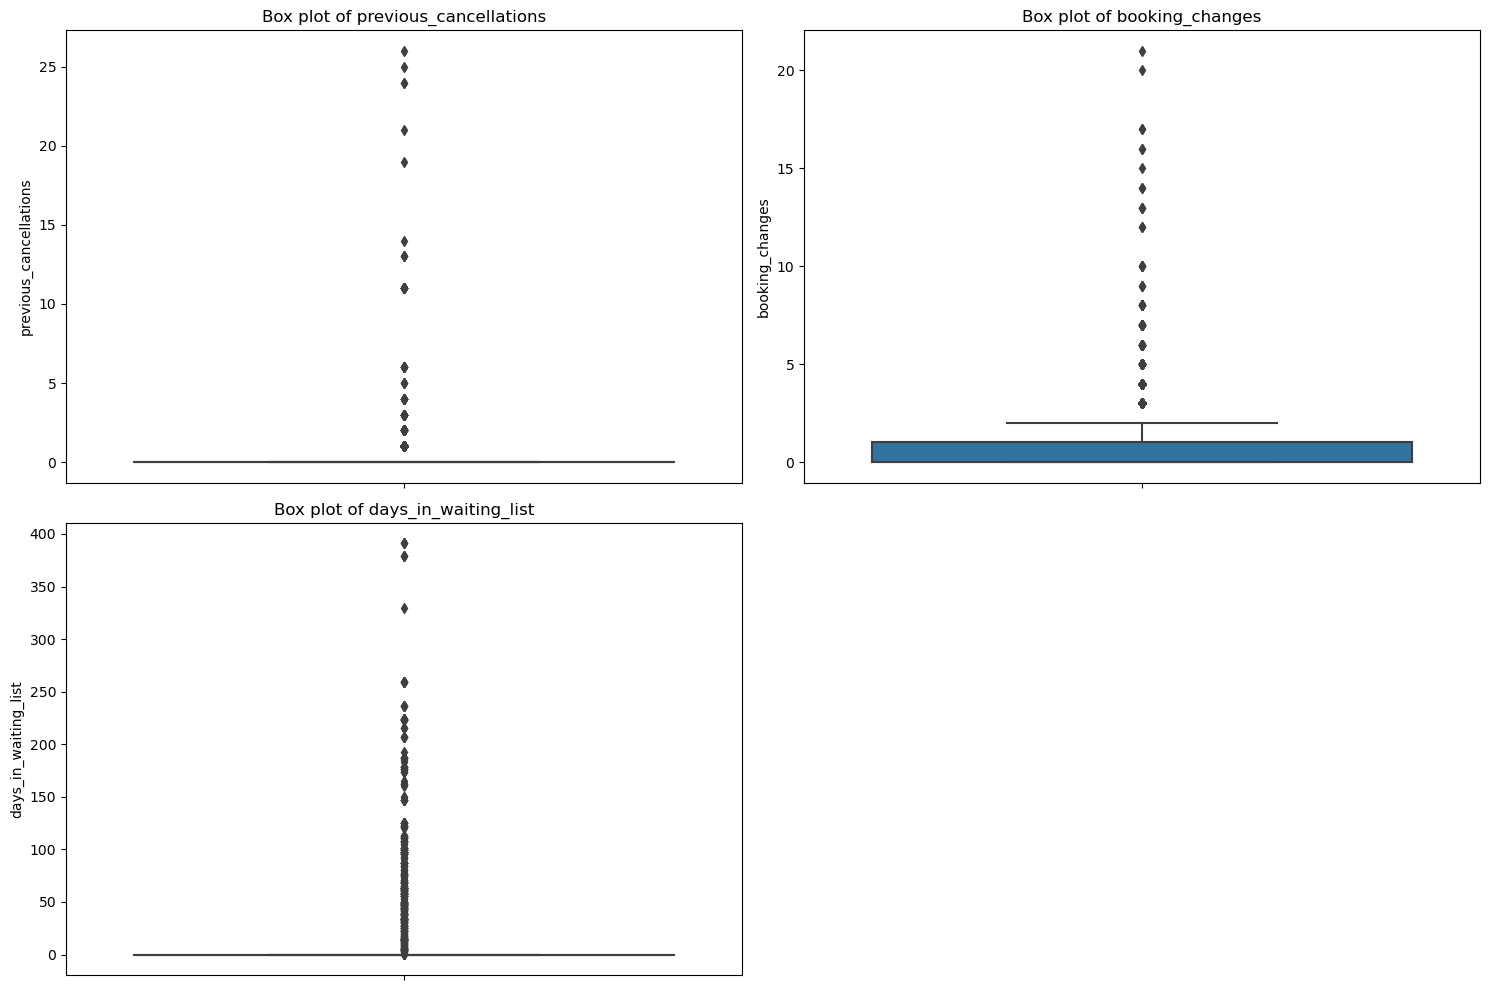

In [7]:
numerical_columns = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

there are many outliers in the 'previous_cancellations', 'booking_changes', and "days_in_waiting_list". Although they are many in numbers, they will not be removed as these data points are important when we want to make a classification model. (I.E. the longer the customer is in the waiting list, it is more likely that they will cancel their booking)

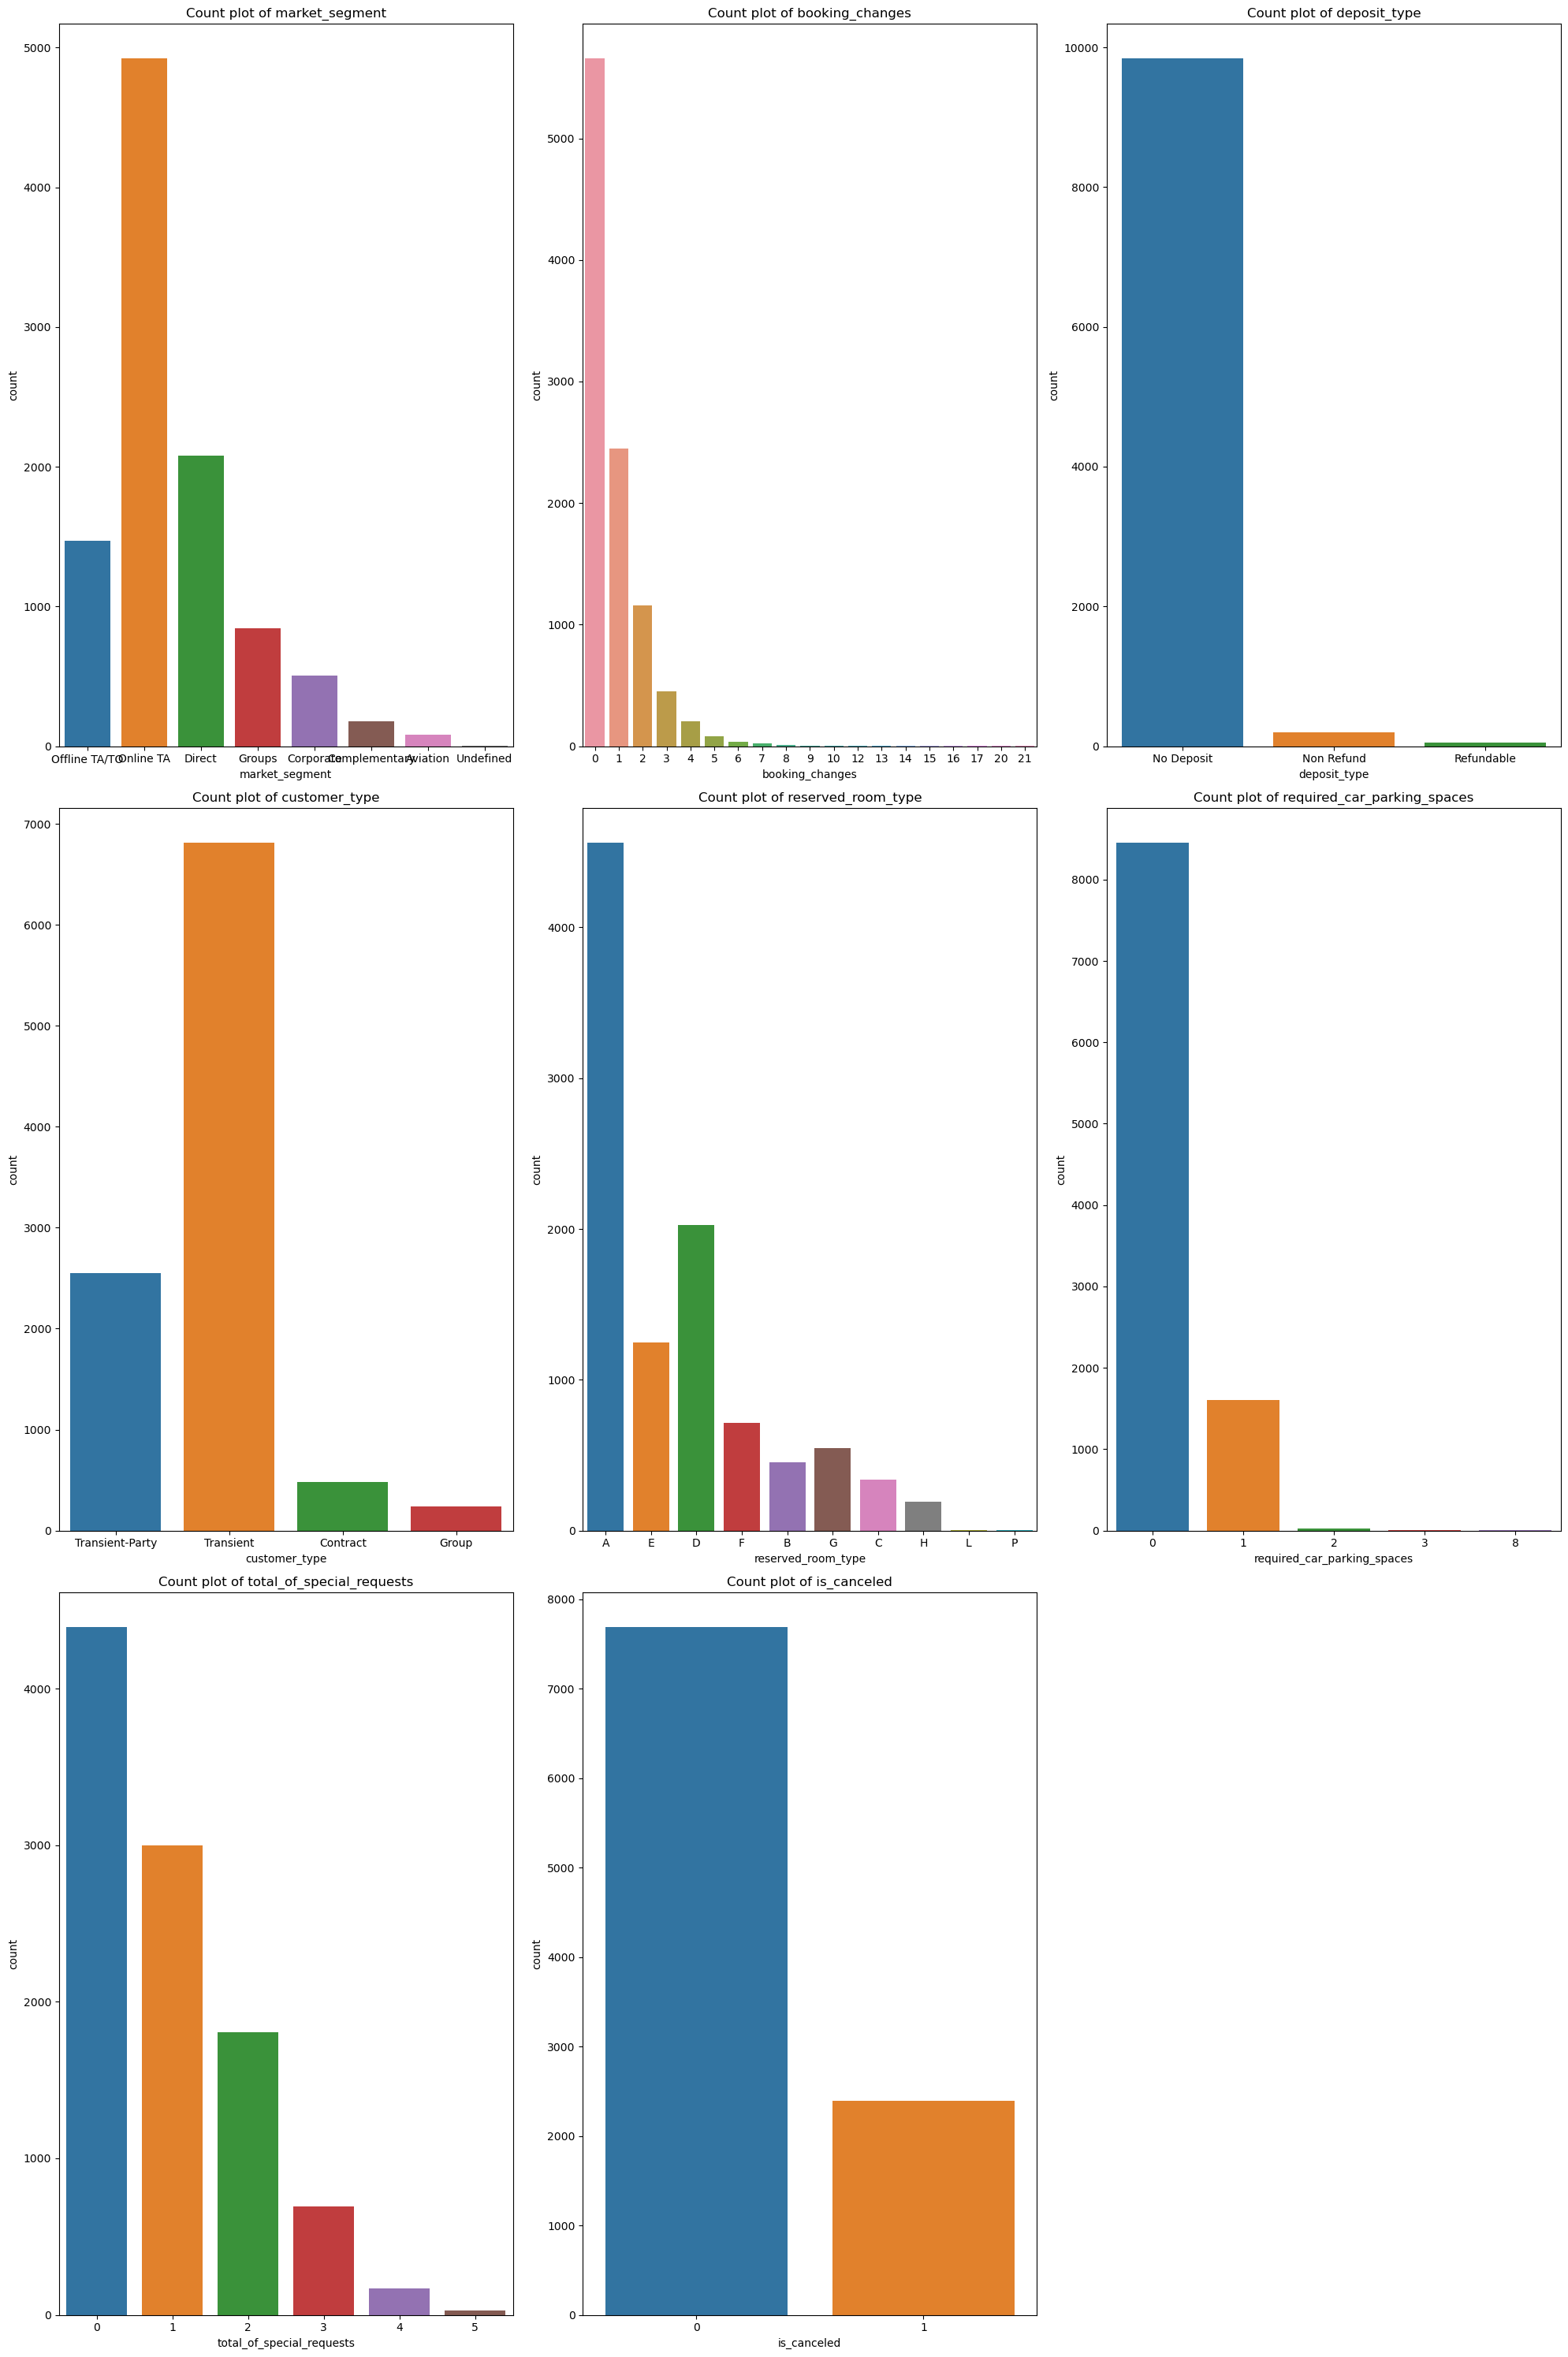

In [8]:
columns = ['market_segment','booking_changes', 'deposit_type',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled']

# Plot count plots for all columns
plt.figure(figsize=(20, 30))
for i, column in enumerate(columns, 1):
    plt.subplot(len(columns) // 3 + 1, 3, i)
    sns.countplot(x=df[column])
    plt.title(f'Count plot of {column}')
plt.tight_layout()
plt.show()

# **Define X and y**

In [9]:
X = df.drop(columns='is_canceled')
y = df['is_canceled']

# **Data Splitting**

In [10]:
X_train, X_test, y_train, y_test =  train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify = y)

# **Data Preprocessing**

In [11]:
# Columns with 5 or fewer unique values
onehot_columns = ['deposit_type', 'customer_type']

# Columns with more than 5 unique values
binary_columns = ['country', 'market_segment', 'reserved_room_type']

# Define the column transformer
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_columns),
        ('binary', BinaryEncoder(), binary_columns)
    ],
    remainder='passthrough'
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(),
                                 ['deposit_type', 'customer_type']),
                                ('binary', BinaryEncoder(),
                                 ['country', 'market_segment',
                                  'reserved_room_type'])])

The code above sets up a column transformer named transformer using scikit-learn's ColumnTransformer class. This transformer applies specific preprocessing techniques to different subsets of columns in a dataset.

- For columns containing 5 or fewer unique values, one-hot encoding is applied. One-hot encoding is used to transform categorical variables into a binary format where each unique value becomes a separate binary feature column.

- For columns containing more than 5 unique values, binary encoding is used. Binary encoding is a technique that transforms categorical variables into binary numbers, reducing the dimensionality of the data while preserving the information.

- The remainder='passthrough' parameter ensures that columns not specified in the onehot_columns and binary_columns lists are passed through without any transformation.

# **Cross Validation**

In [12]:
# define dectree
tree = DecisionTreeClassifier(random_state = 0)

# random forest
rf = RandomForestClassifier(random_state = 0)

# define ada boost
adaboost = AdaBoostClassifier(random_state = 0)

# define gradient boost
gradboost = GradientBoostingClassifier(random_state = 0)

# define xgboost
xgboost = XGBClassifier(random_state = 0)

In [13]:
# Cross Validation

models = [tree, rf, adaboost, gradboost, xgboost]
cv_all = []
cv_mean = []
cv_std = []

for i in models:
    # pipe model
    pipe_model =  Pipeline([("preprocessing", transformer),
                            ("modeling", i)])
    
    # cross_val
    crossval = cross_val_score(
                                estimator = pipe_model,
                                X = X_train,
                                y = y_train,
                                cv = 5,
                                n_jobs = -1,
                                scoring = 'f1'
                                )
    
    cv_all.append(crossval.round(2))
    cv_mean.append(crossval.mean())
    cv_std.append(crossval.std())

In [14]:
df_score = pd.DataFrame()
df_score["algo"] = models
df_score["all_score"] = cv_all
df_score["mean_score"] = cv_mean
df_score["std_score"] = cv_std

df_score

,algo,all_score,mean_score,std_score
0,DecisionTreeClassifier(random_state=0),"[0.29, 0.33, 0.25, 0.28, 0.32]",0.296135,0.030620
1,RandomForestClassifier(random_state=0),"[0.31, 0.37, 0.28, 0.32, 0.31]",0.318083,0.027799
2,AdaBoostClassifier(random_state=0),"[0.37, 0.45, 0.34, 0.38, 0.46]",0.399036,0.047066
3,GradientBoostingClassifier(random_state=0),"[0.36, 0.44, 0.3, 0.35, 0.42]",0.371756,0.050684
4,"XGBClassifier(base_score=None, booster=None, c...","[0.43, 0.49, 0.37, 0.43, 0.44]",0.430465,0.035944


Based on the cross-validation results, we can draw the following conclusions:

- Decision Tree Classifier: 

This model has a mean F1 score of approximately 0.296 with a standard deviation of 0.031. It shows relatively low performance compared to other models.

- Random Forest Classifier: 

With a mean F1 score of around 0.318 and a standard deviation of 0.028, the Random Forest model performs slightly better than the Decision Tree model but still falls short compared to more advanced ensemble methods.

- AdaBoost Classifier: 

AdaBoost demonstrates improved performance with a mean F1 score of about 0.399 and a standard deviation of 0.047. It outperforms both Decision Trees and Random Forests, suggesting that its boosting technique effectively learns from misclassified instances.

- Gradient Boosting Classifier: 

This model shows similar performance to AdaBoost, with a mean F1 score of approximately 0.372 and a standard deviation of 0.051. Gradient Boosting, like AdaBoost, iteratively improves upon the weaknesses of previous models, resulting in better performance.

- XGBoost Classifier: 

XGBoost emerges as the top performer among the models considered, with a mean F1 score of around 0.430 and a standard deviation of 0.036. It consistently outperforms other models, showcasing its robustness and effectiveness in handling classification tasks.

In summary, while all models demonstrate some level of predictive capability, the XGBoost Classifier consistently outperforms the others in terms of F1 score. It presents a promising choice for further optimization and deployment in practical applications.

# **Imbalanced Treatment**

In [15]:
df["is_canceled"].value_counts()

is_canceled
0    7688
1    2396
Name: count, dtype: int64

In [16]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.pipeline import Pipeline

In [17]:
ros = RandomOverSampler(random_state = 0)
rus = RandomUnderSampler(random_state = 0)
smote = SMOTE(sampling_strategy = "minority", random_state = 0)
nm = NearMiss(sampling_strategy = "majority")

In [18]:
# Define model
model = XGBClassifier(random_state=0)

# Iteration sampling method
list_method = [ros, rus, smote, nm]

# List to store F1 scores
list_f1 = []

# Pipeline
for i in list_method:
    pipe_prep_model = Pipeline([("preprocessing", transformer),
                                ("resampling", i),
                                ("modeling", model)
                                ])
    # Fit
    pipe_prep_model.fit(X_train, y_train)

    # Predict
    y_pred = pipe_prep_model.predict(X_test)

    # F1 score
    f1 = f1_score(y_test, y_pred)
    list_f1.append(f1)

In [19]:
df_imb = pd.DataFrame()
df_imb["method"] = list_method
df_imb["f1_score"] = list_f1
df_imb

,method,f1_score
0,RandomOverSampler(random_state=0),0.579383
1,RandomUnderSampler(random_state=0),0.571228
2,"SMOTE(random_state=0, sampling_strategy='minor...",0.449704
3,NearMiss(sampling_strategy='majority'),0.387153


**Insight**:

Based on the provided f1_score results for different resampling methods:

- RandomOverSampler achieved the highest f1_score of 0.579, indicating a balanced performance in terms of precision and recall. This method effectively mitigates class imbalance by oversampling the minority class instances.

- RandomUnderSampler achieved a slightly lower f1_score of 0.571 compared to RandomOverSampler. Despite this, it still offers a viable solution for handling class imbalance by randomly removing instances from the majority class.

- SMOTE, while commonly used for oversampling, resulted in a lower f1_score of 0.450 compared to the other methods. This suggests that the synthetic samples generated by SMOTE may not have effectively represented the underlying data distribution.

- NearMiss, which undersamples the majority class by selecting samples closest to the minority class, yielded the lowest f1_score of 0.387. This indicates that NearMiss may have removed too many instances from the majority class, leading to a loss of important information and reduced performance.

In summary, RandomOverSampler appears to be the most effective resampling method in this context, as it achieved the highest f1_score and provided a good balance between precision and recall. 

# **Hyperparameter tuning**

In [20]:
hyperparam = {
    'modeling__n_estimators': np.arange(50, 1001, 50),
    'modeling__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'modeling__max_depth': np.arange(3, 21, 2),
    'modeling__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'modeling__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the pipeline
pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("resampling", ros),
    ("modeling", XGBClassifier(random_state=0))
])

# grid_search = GridSearchCV(
#     estimator=pipe_model,
#     param_grid=hyperparam,
#     cv=5,
#     scoring='f1',
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

random_search = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam,
    n_iter=500,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['deposit_type',
                                                                                'customer_type']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['country',
                                                                                'market_segment',
                                                                                'reserved_room_type'])])),
                                             ('resampling',
                                              RandomOverSampler(random_state=0)),
                                             ('modeling',
                                              XGBClassifier(base_score=N...
                   param_distributions={'modeling__colsample_bytree': [0.5, 0.6,
                                                                       0.7, 0.8,
                                                                       0.9,
                                                                       1.0],
                                        'modeling__learning_rate': [0.01, 0.05,
                                                                    0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3],
                                        'modeling__max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'modeling__n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'modeling__subsample': [0.5, 0.6, 0.7,
                                                                0.8, 0.9,
                                                                1.0]},
                   random_state=42, scoring='f1', verbose=2)

# **Modeling**

**Benchmark Model**

In [21]:
# Train a default model without hyperparameter tuning
default_model = Pipeline([
    ("preprocessing", transformer),
    ("resampling", rus),
    ("modeling", XGBClassifier(random_state=0))
])

# Fit the default model
default_model.fit(X_train, y_train)

# Make predictions with the default model
y_pred_default = default_model.predict(X_test)

# Evaluate the default model using the F2 score
f1_score_default = f1_score(y_test, y_pred_default)
print("F1 Score with the default model: {:.4f}".format(f1_score_default))

F1 Score with the default model: 0.5712


**Tuned Model**

In [22]:
# Re-train the model with the best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model using the F2 score
f1_score_best = f1_score(y_test, y_pred_best)
print("F1 Score with the best model: {:.4f}".format(f1_score_best))

F1 Score with the best model: 0.5889


In [23]:
# Train the best model after GridSearchCV
pipe_model.set_params(**random_search.best_params_)
pipe_model.fit(X_train, y_train)
y_pred_best = pipe_model.predict(X_test)

# Metrics for the best model after tuning
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
f2_best = fbeta_score(y_test, y_pred_best, beta=2)

# Train the default model for comparison
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)

# Metrics for the default model
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)
f2_default = fbeta_score(y_test, y_pred_default, beta=2)

# Create a DataFrame to compare the models
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'],
    'Default Model': [accuracy_default, precision_default, recall_default, f1_default, f2_default],
    'Tuned Model': [accuracy_best, precision_best, recall_best, f1_best, f2_best]
})

comparison_df

,Metric,Default Model,Tuned Model
0,Accuracy,0.697075,0.720377
1,Precision,0.430233,0.452408
2,Recall,0.849687,0.843424
3,F1 Score,0.571228,0.588921
4,F2 Score,0.711041,0.719117



The table presents performance metrics for both the default and tuned models, providing insights into their classification effectiveness. Explanation of each metric:

- Accuracy: 

The accuracy metric indicates the proportion of correctly classified instances out of the total number of instances. The tuned model exhibits an improved accuracy of 0.720 compared to the default model's accuracy of 0.697, suggesting that the tuning process enhanced the model's overall classification accuracy.

- Precision: 

Precision measures the proportion of true positive predictions out of all positive predictions made by the model. The tuned model demonstrates a higher precision of 0.452 compared to the default model's precision of 0.430. This indicates that the tuned model has a better ability to correctly identify true positive cases while reducing false positives.

- Recall: 

Recall, also known as sensitivity, measures the proportion of true positive instances that are correctly identified by the model out of all actual positive instances. The default model achieved a higher recall of 0.850 compared to the tuned model's recall of 0.843. Although the difference is minimal, it suggests that the default model may have been slightly better at capturing all positive instances.

- F1 Score: 

The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. The tuned model achieved a higher F1 score of 0.589 compared to the default model's F1 score of 0.571, indicating an overall improvement in both precision and recall.

- F2 Score: 

The F2 score is similar to the F1 score but places more emphasis on recall. The tuned model achieved a slightly higher F2 score of 0.719 compared to the default model's F2 score of 0.711. This suggests that while the default model may have had a slightly higher recall, the tuned model strikes a better balance between precision and recall, leading to a higher overall F2 score.

The tuned model demonstrates improvements across multiple performance metrics compared to the default model, indicating that the tuning process has enhanced the model's classification capability and overall effectiveness.

In [24]:
from sklearn.metrics import classification_report

In [25]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_best)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.65      0.77      1538
           1       0.43      0.85      0.57       479

    accuracy                           0.70      2017
   macro avg       0.68      0.75      0.67      2017
weighted avg       0.81      0.70      0.72      2017

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.68      0.79      1538
           1       0.45      0.84      0.59       479

    accuracy                           0.72      2017
   macro avg       0.69      0.76      0.69      2017
weighted avg       0.82      0.72      0.74      2017



**Conclusion**

Based on the results of our model's classification report, we can conclude that if we use our model to predict hotel booking cancellations, our model can reduce the number of cancelled bookings we encounter by approximately 80%. Additionally, we can capture around 84% of the bookings that are actually cancelled (based on recall).

Our model has a prediction accuracy for cancelled bookings of approximately 45% (precision). This means that for every prediction our model makes that a booking will be cancelled, the likelihood of that prediction being correct is approximately 45%. Hence, there will still be bookings that are not actually cancelled but are predicted to be cancelled, making up about 17% of all bookings that are not cancelled (based on recall).

Suppose the cost for managing a cancelled booking per reservation is $171 (based on the following [reference](https://www.budgetyourtrip.com/hotels/united-states-of-america-US)), and assuming we have a total of 10000 bookings a year (where we assume 5000 are cancelled, and 5000 are not cancelled), the calculations would roughly be as follows:

Without Machine Learning (we manage all bookings):

- Total Cost => 10000 x $171 USD = $1,710,000 USD
- Total Cancelled Bookings Captured => 5000 bookings (because we manage all bookings)
- Total Cancelled Bookings Missed => 0 bookings (because we manage all bookings)
- Wasted Cost => 5000 x $171 USD = $855,000 USD (because 5000 bookings are cancelled and it's wasted)
- Total Savings => $0 USD


With Machine Learning (only bookings predicted by the model as cancelled are managed):

- Total Cost => (4200 x $171 USD) + (850 x $171 USD) = $718,200 USD + $145,170 USD = $863,370 USD
- Total Cancelled Bookings Captured => 4200 bookings (because recall for cancelled bookings is 84%)
- Total Cancelled Bookings Missed => 800 bookings (because recall for cancelled bookings is 84%)
- Wasted Cost => 850 x $171 USD = $145,170 USD (based on recall for not cancelled bookings (850 bookings are wrongly managed))
- Total Savings => 4150 x $171 USD = $710,850 USD (calculated only for those bookings which are truly not cancelled; those cancelled but not managed are not counted here)

Based on this example calculation, it appears that by using our model, the company will save a significant amount of costs without sacrificing too many bookings that are actually cancelled.

**Recommendations**

- Implement the tuned model for predicting hotel booking cancellations to reduce unnecessary approaches to customers who are unlikely to cancel their bookings.
- Utilize the model to identify potential cancellations with a higher accuracy rate, thereby optimizing resources and reducing operational costs.
- Regularly monitor and update the model to maintain its effectiveness and adapt to changing trends in booking cancellations.
- Consider investing in further research and development to enhance the precision and recall of the model, aiming for even greater cost savings and operational efficiency.

In [26]:
from joblib import dump

# Save the model
dump(best_model, 'model.joblib')

['model.joblib']